# HAVOK non-linear system identification for simple pendulum

In [22]:
import numpy as np
from numpy import random
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data gathering

(<matplotlib.legend.Legend at 0x2649e1a8400>,
 <matplotlib.legend.Legend at 0x2649e344d90>)

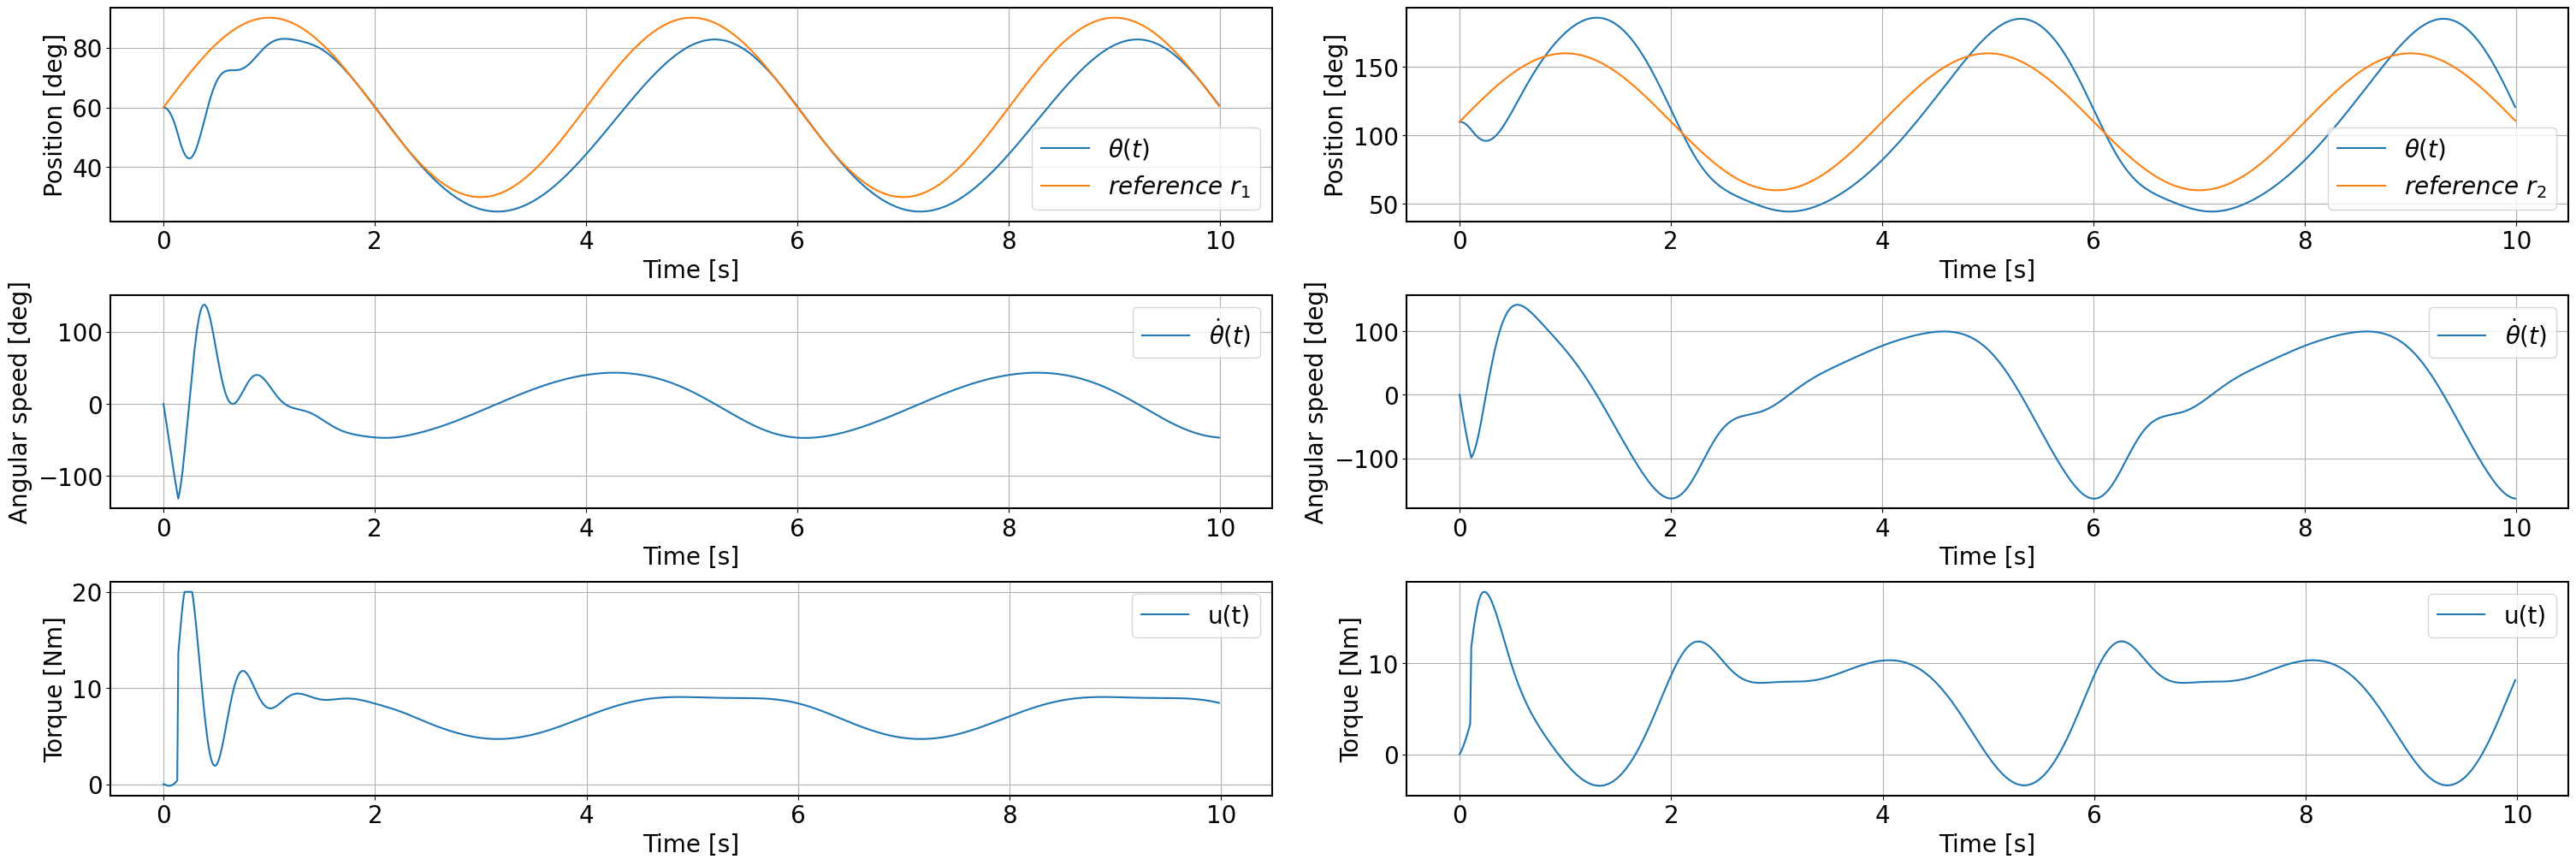

In [19]:
# Pendulum instance
dt = 1e-2
pend1 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(60),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(110),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude1, amplitude2 = 30, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 60)
# pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(70),deg2rad(30)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend1.N, pend1.dt, pend2.T_ref, amplitude2, 110)

# Simulation

for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 10, 1, 40, pend1.dt, 13, limit=20)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 15, 0, 25, pend2.dt, 10, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend1.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend1.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]'), ax[2,1].set_ylabel('Torque [Nm]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

In [7]:
a=[[1,2,3],[1,2,3]]
b=[3,3]

print(hankel())

[[1 2 3 1 2 3 3 4 5 6 7 8 3 3]
 [2 3 1 2 3 3 4 5 6 7 8 3 3 4]
 [3 1 2 3 3 4 5 6 7 8 3 3 4 5]
 [1 2 3 3 4 5 6 7 8 3 3 4 5 6]
 [2 3 3 4 5 6 7 8 3 3 4 5 6 7]
 [3 3 4 5 6 7 8 3 3 4 5 6 7 8]]


In [17]:
pend = pend1
tau = 2
horizon = np.int(pend.N/50)
f1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
f1.matricesConstruction()
print(f1.Phi.T)
U,S,V = svd(f1.Phi)
y = V.T

yu = [y(:,1:end-1); u_demo];

[[ 1.21585 -0.72352  1.22305 -0.71599  8.82321]
 [ 1.20858 -0.73077  1.21585 -0.72352  8.81117]
 [ 1.20124 -0.73776  1.20858 -0.73077  8.79846]
 [ 1.19383 -0.74448  1.20124 -0.73776  8.78507]
 [ 1.18635 -0.75093  1.19383 -0.74448  8.77098]
 [ 1.17881 -0.75712  1.18635 -0.75093  8.75618]
 [ 1.17121 -0.76302  1.17881 -0.75712  8.74066]
 [ 1.16355 -0.76866  1.17121 -0.76302  8.72441]
 [ 1.15584 -0.77403  1.16355 -0.76866  8.70742]
 [ 1.14807 -0.77912  1.15584 -0.77403  8.68967]
 [ 1.14025 -0.78394  1.14807 -0.77912  8.67117]
 [ 1.13239 -0.78848  1.14025 -0.78394  8.6519 ]
 [ 1.12448 -0.79276  1.13239 -0.78848  8.63186]
 [ 1.11654 -0.79677  1.12448 -0.79276  8.61105]
 [ 1.10855 -0.8005   1.11654 -0.79677  8.58946]
 [ 1.10053 -0.80397  1.10855 -0.8005   8.56708]
 [ 1.09247 -0.80717  1.10053 -0.80397  8.54392]
 [ 1.08438 -0.81011  1.09247 -0.80717  8.51998]
 [ 1.07627 -0.81278  1.08438 -0.81011  8.49525]
 [ 1.06813 -0.81518  1.07627 -0.81278  8.46974]]


In [70]:
pend = pend1
horizon = 100
model1 = HAVOK(pend.X, pend1.U)
model1.HANKEL(horizon)

model1.SVD(tau=5)
model1.LS()
print(model1.A.shape,model1.B.shape,model1.C.shape)

(5, 5) (5, 1) (2, 5)
